In [19]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

FONT_COLOR = "#22373a"
FILL_COLOR = "#b4cccf"

plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.25
plt.rcParams["grid.color"] = "#cccccc"

pd.options.display.max_columns = 999


In [22]:
RESULTS = {
    1: {
        "CEPS": "CEPS1.db",
        "FT-CEPS": "FT_CEPS1.db",
        "S-CEPS": "MY_CEPS1.db",
        "FT-S-CEPS": "FT_MY_CEPS1.db"
    },
    2: {
        "CEPS": "CEPS2.db",
        "FT-CEPS": "FT_CEPS2.db",
        "S-CEPS": "MY_CEPS2.db",
        "FT-S-CEPS": "FT_MY_CEPS2.db"
    },
}

results = {}

for i, result in RESULTS.items():
    ss = []
    for name, db in result.items():
        conn = sqlite3.connect(db)

        df = pd.read_sql_query("SELECT * FROM results", conn)
        conn.close()
        if "FT" in name:
            s = df.loc[df["comment"].str.startswith("finetune")].groupby("instance_id")["cost"].min()
            s = s.rename(name)
        else:
            s = df.loc[df["comment"].str.startswith("test")].pivot_table(index="instance_id", columns="solver_id", values="cost", aggfunc=lambda x: sorted(x)[1])
            s[name] = s.min(axis=1)
            s = s[name]
        ss.append(s)
    results[i] = pd.concat(ss, axis=1)

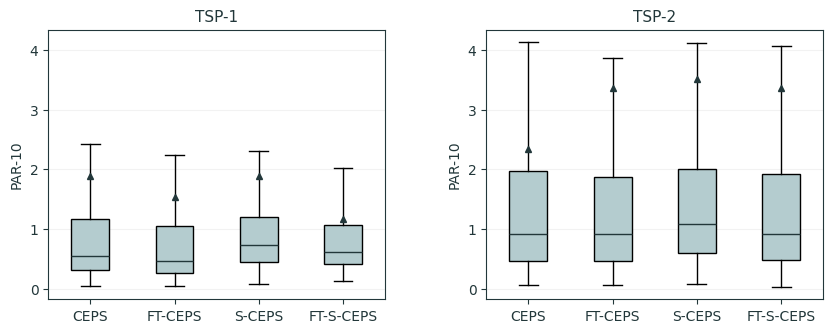

In [23]:
n = len(results)

fig, ax = plt.subplots(ncols=n, nrows=1, figsize=(n * 5, 3.5), sharey=True)

for i, (result_group, result) in enumerate(results.items()):
    ax[i].boxplot(
        result,
        patch_artist=True,
        boxprops=dict(facecolor=FILL_COLOR),
        showfliers=False,
        medianprops=dict(color=FONT_COLOR),
        tick_labels=result.columns,
    )
    for j, label in enumerate(result.columns):
        mean_value = result[label].mean()
        ax[i].plot(
            [j + 1], [mean_value], marker="^", markersize=5, color=FONT_COLOR
        )
    ax[i].yaxis.set_visible(True)
    ax[i].tick_params(axis="y", which="both", labelleft=True)
    ax[i].set_yticks([0, 1, 2, 3, 4])
    ax[i].set_ylabel("PAR-10", color=FONT_COLOR)
    ax[i].set_title(f"TSP-{result_group}", fontsize=11, color=FONT_COLOR)
    ax[i].yaxis.grid(True)
    ax[i].xaxis.grid(False)
    ax[i].spines[["left", "top", "right", "bottom"]].set_color(FONT_COLOR)
    ax[i].tick_params(axis='x', colors=FONT_COLOR)
    ax[i].tick_params(axis='y', colors=FONT_COLOR)

plt.savefig("resuts.png", dpi=300, bbox_inches="tight", transparent=True)
plt.subplots_adjust(wspace=0.3)
plt.show()